# Leaf Frame Processor

## Manual Processing Protocol

Files with '_P.tif' extension have foreground color set to white in the photoshop. Manually ouline of a leaf is drawn. After drawing an outline contrast is adjusted to 100, and it was made sure that the area between leaves and holes are white and leaf area is black. The '_P.jpg' files are being loaded to ImageJ.
Images are then calibrated to actual dimensions. If global opthon was used this indicated that for the same batch of photos with the same DPI the distance in pixels was translated to the same distance in centimeters (maybe I can only have one recalculation that would work fine for each photo). In iJ threshold is adjusted to produce black and white images. Thresholded image is saved with '_PT.tif' extension. This image is the starting point for all lead metrics.
Three images after analysis:
1. _P.jpg, this is the contrast grayscale image;
2. _PT.tif, this is the threshold image;
3. _PTO.tif, this is the outlines file.

Active Shape Model for reconstruction of the leaf blade.

### Descriptions of measurments taken.

- *Area* - Area of selection in square pixels. Area is in calibrated units, such as square millimeters, if Analyze/Set Scale was used to spatially calibrate the image.
- *Centroid* - The center point of the selection. This is the average of the x and y coordinates of all of the pixels in the selection. 
- *Perimeter* - The length of the outside boundary of the selection. 
- *Bounding Rectangle* - The smallest rectangle enclosing the selection. Uses the headings BX, BY, Width and Height, where BX and BY are the coordinates of the upper left corner of the rectangle. (this will provide leaf width and length in sliced scans)
- *Fit Ellipse* - Fit an ellipse to the selection. Uses the headings Major, Minor and Angle. Major and Minor are the primary and seconday axis of the best fitting ellipse. *Angle* is the angle between the primary axis and a line parallel to the x-axis of the image. Note that ImageJ cannot calculate the major and minor axis lengths if Pixel Aspect Ratio in the Set Scale dialog is not 1.0. 
- *Circularity* - 4pi(area/perimeter^2). A value of 1.0 indicates a perfect circle. As the value approaches 0.0, it indicates an increasingly elongated polygon. Values may not be valid for very small particles. 
- *Feret's Diameter* - The longest distance between any two points along the selection boundary. Also known as the caliper length. The Feret's Diameter macro will draw the Feret's Diameter of the current selection on the image. 
- *Limit to Threshold* - If checked, only thresholded pixels are included in measurement calculations. Use Image/Adjust/Threshold to set the threshold limits. 
- *Display Label* - If checked, the image name and slice number (for stacks) are recoded in the first column of the results table. 
- *Decimal Places* - This is the number of digits to the right of the decimal point in real numbers displayed in the results table and in histogram windows. 

## 1.Load data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("/home/piotr/projects/leaf-area/leaf-area/data/03_primary/data_filtered.csv")

In [3]:
data.columns

Index(['label', 'est_area', 'area', 'image_path', 'area_lost',
       'img_id_exists'],
      dtype='object')

## 2. Plot data

Plot an image and explore whether bouding boxes can be extracted.

In [4]:
data_path = ['/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-ADENLA_PTR.xls',
'/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-CAESH_PTR.xls']
img_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images/4-GI-P5-C-ADENLA.JPG'

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path

In [6]:
img_data = pd.read_csv(data_path[1], sep='\t')
print(list(img_data))
img_data.head()

[' ', 'Label', 'Area', 'X', 'Y', 'Perim.', 'BX', 'BY', 'Width', 'Height', 'Major', 'Minor', 'Angle', 'Feret', 'FeretX', 'FeretY', 'FeretAngle', 'MinFeret', 'XStart', 'YStart']


,,Label,Area,X,Y,Perim.,BX,BY,Width,Height,Major,Minor,Angle,Feret,FeretX,FeretY,FeretAngle,MinFeret,XStart,YStart
0,1,4-GI-P5-C-CAESH.P.jpg,8.653,16.324,6.886,15.195,14.894,3.502,2.678,5.748,5.051,2.181,71.145,5.997,15.657,9.250,73.433,2.314,842,170
1,2,4-GI-P5-C-CAESH.P.jpg,2.482,30.027,6.495,7.941,29.336,4.470,1.318,3.276,2.678,1.180,83.641,3.286,29.954,7.746,85.326,1.309,1465,217
2,3,4-GI-P5-C-CAESH.P.jpg,6.311,5.253,9.363,12.666,4.285,6.304,1.998,5.130,4.402,1.825,90.411,5.135,5.171,11.433,87.471,1.968,261,306
3,4,4-GI-P5-C-CAESH.P.jpg,2.514,25.313,10.100,8.016,24.597,8.055,1.339,3.317,2.752,1.163,81.440,3.348,25.092,11.372,82.219,1.304,1238,391
4,5,4-GI-P5-C-CAESH.P.jpg,3.001,42.904,10.342,8.598,42.273,8.240,1.380,3.461,3.064,1.247,100.105,3.563,42.376,8.240,103.715,1.363,2057,400


Convert the measures in cm to pixels. Another thing is this (seems to be) an arbitrary crop of the image such that it is more or less square. Let me see if I can approximate that as well.

In [7]:
import matplotlib
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf',
 '/usr/share/fonts/opentype/urw-base35/NimbusRoman-BoldItalic.otf',
 '/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-BoldItalic.otf',
 '/usr/share/fonts/opentype/urw-base35/URWGothic-DemiOblique.otf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-Italic.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf',
 '/usr/share/fonts/truetype/ubuntu/UbuntuMono-RI.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-Bold.ttf',
 '/usr/share/fonts/opentype/urw-base35/NimbusSans-Italic.otf',
 '/usr/share/fonts/opentype/urw-base35/NimbusSansNarrow-BoldOblique.otf',
 '/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf',
 '/usr/share/fonts/opentype/urw-base35/NimbusSansNarrow-Regular.otf',
 '/usr/share/fonts/opentype/urw-base35/Nimb

In [8]:
# img_data['XStart'] / img_data['X']
PIXELS_PER_CM = 36
OFFSET_X = 650
OFFSET_Y = 300
HEIGHT_EXT = 150
WIDTH_EXT = 150

In [9]:
def plot_image_bounding_boxes(img_data,
                              coordinate_columns = ('xstart_off', 'ystart_off', 'w_px', 'h_px')):
    img_label = img_data['Label'].unique()[0]
    img_label = img_label.replace(".P.jpg", ".JPG")
    img_path = Path('/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images', img_label)
    print(img_path)

    # img_data['ul_bbx_px'] = img_data['BX'] * PIXELS_PER_CM
    # img_data['ul_bby_px'] = img_data['BY'] * PIXELS_PER_CM
    img_data['w_px'] = img_data['Width'] * PIXELS_PER_CM + WIDTH_EXT
    img_data['h_px'] = img_data['Height'] * PIXELS_PER_CM + HEIGHT_EXT
    # img_data['bl_bbx_px'] = img_data['ul_bbx_px']
    # img_data['bl_bby_px'] = img_data['ul_bby_px']
    img_data['xstart_off'] = img_data['XStart'] + OFFSET_X
    img_data['ystart_off'] = img_data['YStart'] + OFFSET_Y
    # img_data['bbx_off'] = img_data['bl_bbx_px'] + OFFSET_X
    # img_data['bby_off'] = img_data['bl_bby_px'] + OFFSET_Y

    # Alternatives
    # coordinate_columns = ('XStart', 'YStart', 'w_px', 'h_px')
    # coordinate_columns = ('bl_bbx_px', 'bl_bby_px', 'w_px', 'h_px')
    # coordinate_columns = ('bbx_off', 'bby_off', 'w_px', 'h_px')

    nrows = img_data.shape[0]

    fig, ax = plt.subplots()

    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    
    # Display the image
    # ax.imshow(img)
    # Create a Rectangle patch for each row in the file
    for rw in range(nrows//2):
        bl_x, bl_y, width, height = (
            img_data[coordinate_columns[0]][rw], 
            img_data[coordinate_columns[1]][rw], 
            img_data[coordinate_columns[2]][rw], 
            img_data[coordinate_columns[3]][rw])
        
        # rect = patches.Rectangle((bl_x, bl_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        # rect = patches.Rectangle((img_data['xstart_off'][rw], img_data['ystart_off'][rw]), 2, 2, linewidth=1, edgecolor='b', facecolor='none')
        # ax.add_patch(rect)
        text = f'Row number: {rw}'
        font = ImageFont.truetype( '/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf', 50)
        draw.rectangle([(bl_x, bl_y), (bl_x+width, bl_y+height)], outline ="red")
        draw.text((bl_x,bl_y), text, fill='white', font=font)
        # ax.add_patch(draw)
        # Add the patch to the Axes
        
    
    # plt.figure(figsize=(20,20))
    img.show()

In [20]:
# data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-ALPHIN_PTR.xls'
# data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-CYPHOLOPHUS-SP2_PTR.xls'
# data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-CYRTER_PTR.xls'
# data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-DEBRLO_PTR.xls'
# data_path ='/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-DUPOND_PTR.xls'
# data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-ELAEDO_PTR.xls'
# data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-FERN-SP5_PTR.xls'
# data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-FICUDA_PTR.xls'
# data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-GASTSP_PTR.xls'
data_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/tables/4-GI-P5-C-GUNNMA_PTR.xls'

img_data = pd.read_csv(data_path, sep='\t')
# print(list(img_data))
# img_data.head()

/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images/4-GI-P5-C-GUNNMA.JPG.JPG


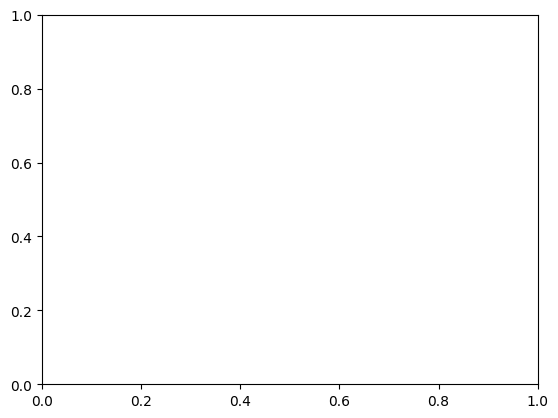

In [21]:
plot_image_bounding_boxes(img_data)

In [ ]:
from typing import List, Tuple

def plot_image_bounding_boxes(img_paths: List[str],
                              coordinate_columns: Tuple[str] = ('xstart_off', 'ystart_off', 'w_px', 'h_px')):
    
    # Create a fugure with boxes
    fig, ax = plt.subplots(1, 2)
    
    # PLOT 1
    
    # For each dataset read data
    img_data = pd.read_csv(img_paths[0], sep='\t')
    img_label = img_data['Label'].unique()[0]
    img_label = img_label.replace(".P.jpg", ".JPG")
    img_path = Path('/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images', img_label)
    print(img_path)
    # Convert the bboxes
    img_data['w_px'] = img_data['Width'] * PIXELS_PER_CM + WIDTH_EXT
    img_data['h_px'] = img_data['Height'] * PIXELS_PER_CM + HEIGHT_EXT
    img_data['xstart_off'] = img_data['XStart'] + OFFSET_X
    img_data['ystart_off'] = img_data['YStart'] + OFFSET_Y
    # Get the number of leaves
    nrows = img_data.shape[0]
       
    img = Image.open(img_path)
    # Display the image
    ax[0].imshow(img)
    # Create a Rectangle patch for each row in the file
    for rw in range(nrows//2):
        bl_x, bl_y, width, height = (
            img_data[coordinate_columns[0]][rw], 
            img_data[coordinate_columns[1]][rw], 
            img_data[coordinate_columns[2]][rw], 
            img_data[coordinate_columns[3]][rw])
        rect = patches.Rectangle((bl_x, bl_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax[0].add_patch(rect)



    # PLOT 2
     # For each dataset read data
    img_data = pd.read_csv(img_paths[1], sep='\t')
    img_label = img_data['Label'].unique()[0]
    img_label = img_label.replace(".P.jpg", ".JPG")
    img_path = Path('/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images', img_label)
    print(img_path)
    # Convert the bboxes
    img_data['w_px'] = img_data['Width'] * PIXELS_PER_CM + WIDTH_EXT
    img_data['h_px'] = img_data['Height'] * PIXELS_PER_CM + HEIGHT_EXT
    img_data['xstart_off'] = img_data['XStart'] + OFFSET_X
    img_data['ystart_off'] = img_data['YStart'] + OFFSET_Y
    # Get the number of leaves
    nrows = img_data.shape[0]
    img = Image.open(img_path)
    # Display the image
    ax[1].imshow(img)
    # Create a Rectangle patch for each row in the file
    for rw in range(nrows//2):
        bl_x, bl_y, width, height = (
            img_data[coordinate_columns[0]][rw], 
            img_data[coordinate_columns[1]][rw], 
            img_data[coordinate_columns[2]][rw], 
            img_data[coordinate_columns[3]][rw])
        rect = patches.Rectangle((bl_x, bl_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax[1].add_patch(rect)

    plt.show()

TypeError: plot_image_bounding_boxes() got an unexpected keyword argument 'img_paths'

/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images/4-GI-P5-C-ADENLA.JPG
/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images/4-GI-P5-C-CAESH.JPG


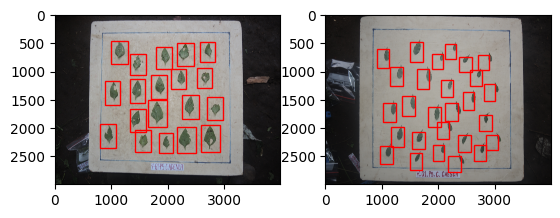

In [105]:
plot_image_bounding_boxes(img_paths=data_path)

In [35]:
# # import cv2
# # img = cv2.imread(data['image_path'][idx])
# # from matplotlib import pyplot as plt
# # plt.imshow(img, interpolation='nearest')
# # plt.show()

# import matplotlib.pyplot as plt
# from PIL import Image

# img_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images/4-GI-P5-C-ACHYRANTHES-SP1.JPG'
# print(img_path)
# img_path = data['image_path'][1]
# img_path = '/home/piotr/projects/leaf-area/leaf-area/data/02_intermediate/images/Y-G2-P3-H-PIPESU.JPG'
# print(img_path)



# img = Image.open(data['image_path'][1])

# plt.imshow(img)

In [22]:
from roboflow import Roboflow
rf = Roboflow(api_key="onQHDhSGeUEnGY4e1Qq7")
project = rf.workspace("leafframes").project("leaf-area-zxdye")
version = project.version(1)
dataset = version.download("coco")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to leaf-area-1 in coco:: 100%|██████████| 14/14 [00:00<00:00, 442.20it/s]


In [25]:
dataset.model_format

'coco'

## Outline

YOLO will initially detect indiviudal leaves at images. These leaves are going to be trimmed according to their bounding boxes. These individual leaves then are going to be used as input to a autoencoder architecture to predict the leaf area lost to hearbivory.

In [ ]:
import torch

model = torch.ub.load('ultralytics/yolov5', )